In [1]:
import copy
import matplotlib
import pandas
import warnings
import requests
import scipy
from scipy import stats
import subprocess
import numpy as np
import numpy
from matplotlib import pyplot as plt
import json
import seaborn
import networkx as nx
import curatorbin

In [2]:
task_id = "sys_perf_linux_standalone_sliding_windows_d3b36587bc2222fdefa1c755bb253f78c894496c_21_10_18_23_44_45"
metric_name = "SlidingWindows.MovingAvgPositionBased"
# task_id = "None"
# metric_name = "None"

In [3]:
task_record = requests.get(f"https://cedar.mongodb.com/rest/v1/perf/task_id/{task_id}").json()

In [4]:
tests = [t for t in task_record if metric_name in t["info"]["test_name"]]

In [5]:
if len(tests) == 0:
    raise ValueError("The metric requested does not exist")

metric_record = tests[0]

In [6]:
def make_differential_frame(df, dx):
    b = pandas.DataFrame()
    b[dx] = df[dx]
    b["d(t_pure)"] = df["d(t_pure)"]
    b["d(t_total)"] = df["d(t_total)"]
    b["d(t_overhead)"] = df["d(t_overhead)"]
    
    b["total_latency"] = b["d(t_total)"] / b[dx]
    b["overhead_latency"] = b["d(t_overhead)"] / b[dx]
    b["pure_latency"] = b["d(t_pure)"] / b[dx]
    b["ts"] = df["ts"]
    b["actor_id"] = df["actor_id"]
    
    # Have a single row for every sample/increment
    b = b.loc[b.index.repeat(b[dx])]
    
    return b

In [7]:
def get_data(result):
    r = requests.get(result["artifacts"][0]["download_url"])
    with open(f"{metric_name}.ftdc", "wb") as f:
        f.write(r.content)
    try:
        subprocess.check_call(f"rm {metric_name}.csv", shell=True)
    except:
        pass
    curatorbin.run_curator("ftdc", "export", "csv", "--input", f"{metric_name}.ftdc", "--output", f"{metric_name}.csv")
    # subprocess.check_call(f"curator ftdc export csv --input ./response2.ftdc --output {metric_name}.csv", shell=True)
    df = pandas.read_csv(f"./{metric_name}.csv")
    return df

In [8]:
# data, data_differential, data_raw = get_data(metric_record)
data = get_data(metric_record)

In [9]:
for field in ["counters.n", "counters.ops", "counters.size", "counters.errors", "timers.dur", "timers.total"]:
    data[field] = data[field].diff().fillna(data[field])
for field in ["timers.dur", "timers.total"]:
    data[field] = data[field] / 1e+9
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    data["ts"] = pandas.to_datetime(data["ts"])
    data["ts"] = data["ts"].dt.to_period("1s") # Sample the timestamps down to 1 second granularity.


In [10]:
b = pandas.DataFrame()
b["throughput"] = data.groupby("ts").count()["id"]
b["latency"] = data.groupby("ts").mean()["timers.dur"]
b["latency-median"] = data.groupby("ts").median()["timers.dur"]
b["latency-max"] = data.groupby("ts").max()["timers.dur"]

array([<AxesSubplot:xlabel='ts'>, <AxesSubplot:xlabel='ts'>,
       <AxesSubplot:xlabel='ts'>, <AxesSubplot:xlabel='ts'>], dtype=object)

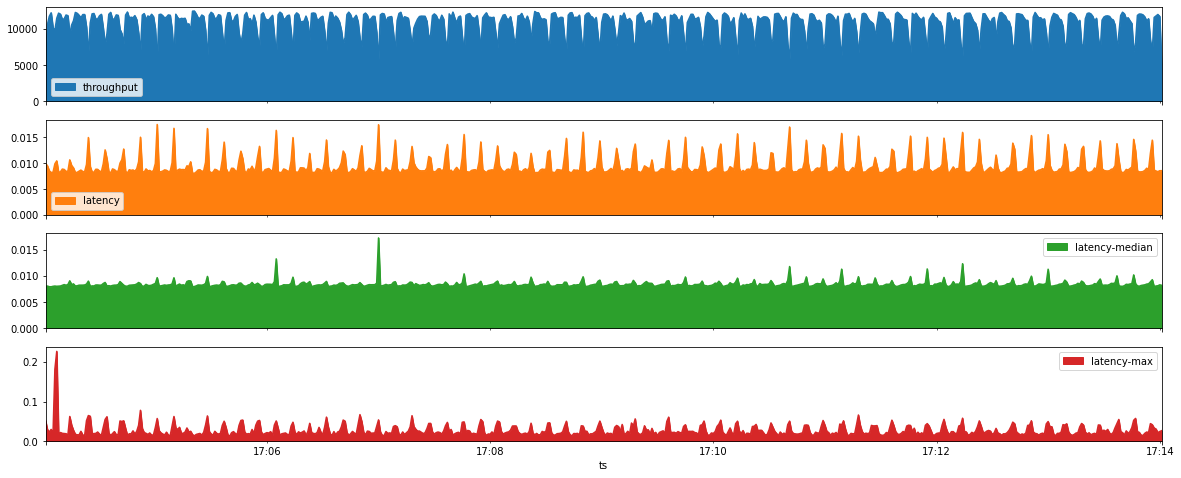

In [11]:
b.plot.area(figsize=(20,8), subplots=True)
